In [1]:
%matplotlib inline
import composeml as cp
import featuretools as ft
import pandas as pd
import data

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
df = data.load('data/train_FD004.txt')
df[df.columns[:7]].head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2
0,1,1,10.0047,0.2501,20.0,489.05,604.13
1,1,2,0.0015,0.0003,100.0,518.67,642.13
2,1,3,34.9986,0.8401,60.0,449.44,555.42
3,1,4,20.0031,0.7005,0.0,491.19,607.03
4,1,5,42.0041,0.8405,40.0,445.00,549.52


In [3]:
def remaining_useful_life(df):
    return len(df) - 1

In [4]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

In [5]:
lt = lm.search(
    df.sort_values('time'),
    num_examples_per_instance=10,
    minimum_data=100,
    gap=1,
    verbose=True,
)

lt.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 2180/2180 


,engine_no,time,remaining_useful_life
id,,,
0,1,2000-01-01 16:40:00,122
1,1,2000-01-01 16:50:00,121
2,1,2000-01-01 17:00:00,120
3,1,2000-01-01 17:10:00,119
4,1,2000-01-01 17:20:00,118


In [6]:
lt.describe()

Settings
--------
gap                                              1
label_type                              continuous
labeling_function            remaining_useful_life
minimum_data                                   100
num_examples_per_instance                       10
target_entity                            engine_no
window_size                                  45918


Transforms
----------
No transforms applied



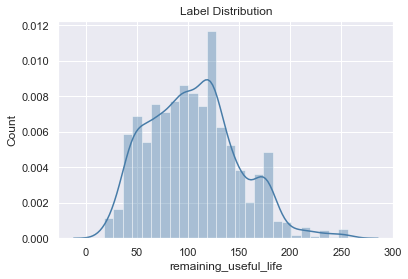

In [7]:
lt.plot.distribution();

In [8]:
lt = lt.bin(4, quantiles=True)

In [9]:
lt.describe()

Label Distribution
------------------
(103.0, 131.0]     543
(131.0, 256.0]     539
(17.999, 71.0]     551
(71.0, 103.0]      547
Total:            2180


Settings
--------
gap                                              1
label_type                                discrete
labeling_function            remaining_useful_life
minimum_data                                   100
num_examples_per_instance                       10
target_entity                            engine_no
window_size                                  45918


Transforms
----------
1. bin
  - bins:            4
  - labels:       None
  - quantiles:    True
  - right:        True



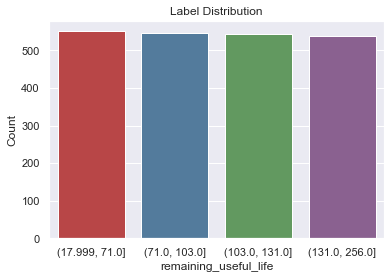

In [10]:
lt.plot.distribution();

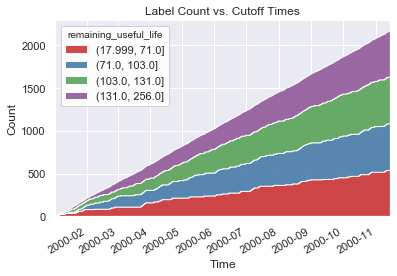

In [11]:
lt.plot.count_by_time();

In [12]:
es = ft.EntitySet('observations')

es.entity_from_dataframe(
    dataframe=df,
    entity_id='recordings',
    index='id',
    time_index='time',
    make_index=True,
)

es.normalize_entity(
    base_entity_id='recordings',
    new_entity_id='engines',
    index='engine_no',
)

es.normalize_entity(
    base_entity_id='recordings',
    new_entity_id='cycles',
    index='time_in_cycles',
)

Entityset: observations
  Entities:
    recordings [Rows: 45918, Columns: 28]
    engines [Rows: 218, Columns: 2]
    cycles [Rows: 357, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

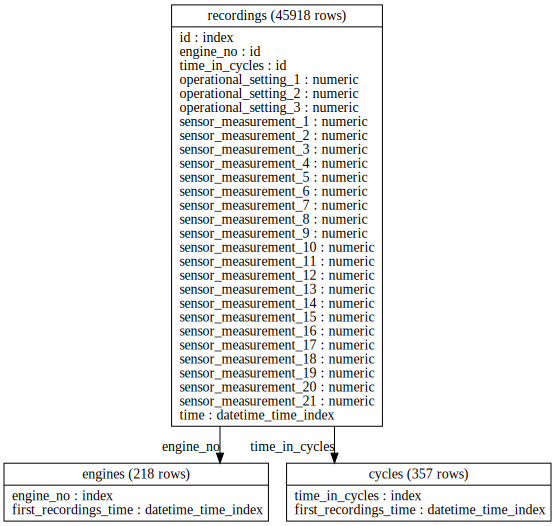

In [13]:
es.plot()

In [14]:
lt = lt.sample(frac=.2, random_state=0)

In [15]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', 'min'],
    trans_primitives=[],
    cutoff_time=lt,
    cutoff_time_in_index=True,
    max_depth=3,
    verbose=True,
)

fm.head()

Built 292 features
Elapsed: 02:41 | Progress: 100%|██████████


,,LAST(recordings.sensor_measurement_16),LAST(recordings.sensor_measurement_1),LAST(recordings.operational_setting_1),LAST(recordings.operational_setting_3),LAST(recordings.sensor_measurement_13),LAST(recordings.sensor_measurement_20),LAST(recordings.sensor_measurement_18),LAST(recordings.sensor_measurement_9),LAST(recordings.sensor_measurement_7),LAST(recordings.sensor_measurement_2),...,MIN(recordings.cycles.MIN(recordings.sensor_measurement_6)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_4)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_19)),MIN(recordings.cycles.MIN(recordings.operational_setting_3)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_8)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_18)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_21)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_13)),MIN(recordings.cycles.LAST(recordings.sensor_measurement_15)),remaining_useful_life
engine_no,time,,,,,,,,,,,,,,,,,,,,,
170,2000-09-04 09:40:00,0.02,491.19,20.0032,0.0,2388.04,24.56,2324,8730.80,334.35,607.16,...,5.71,1029.49,100.0,0.0,2388.13,2388,23.4219,2388.22,8.3791,"(131.0, 256.0]"
47,2000-03-09 21:30:00,0.02,491.19,20.0069,0.0,2388.06,24.69,2324,8733.99,335.13,606.80,...,5.71,1033.53,100.0,0.0,2388.03,2388,23.3181,2388.16,8.3657,"(103.0, 131.0]"
132,2000-07-10 20:50:00,0.03,489.05,10.0052,20.0,2388.18,28.50,2319,8764.08,394.42,604.96,...,5.71,1029.49,100.0,0.0,2388.13,2388,23.4031,2388.20,8.3972,"(71.0, 103.0]"
57,2000-03-25 00:10:00,0.03,518.67,0.0002,100.0,2388.11,38.78,2388,9069.88,553.26,642.80,...,5.71,1033.53,100.0,0.0,2388.07,2388,23.3331,2388.16,8.4053,"(17.999, 71.0]"
113,2000-06-14 02:20:00,0.02,449.44,35.0043,60.0,2388.22,14.91,2223,8361.88,194.67,555.51,...,5.71,1029.49,100.0,0.0,2388.12,2388,23.4029,2388.19,8.3797,"(17.999, 71.0]"


In [16]:
y = fm.pop(lt.label_name)
y = y.astype('str')

x = fm.fillna(0)
x, fe = ft.encode_features(x, fd)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=.8,
    test_size=.2,
    random_state=0,
)

In [18]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [19]:
y_hat = clf.predict(x_test)
print(classification_report(y_test, y_hat))

                precision    recall  f1-score   support

(103.0, 131.0]       0.65      0.74      0.69        23
(131.0, 256.0]       0.41      0.53      0.46        17
(17.999, 71.0]       0.81      0.70      0.75        30
 (71.0, 103.0]       0.64      0.50      0.56        18

      accuracy                           0.64        88
     macro avg       0.63      0.62      0.62        88
  weighted avg       0.66      0.64      0.64        88



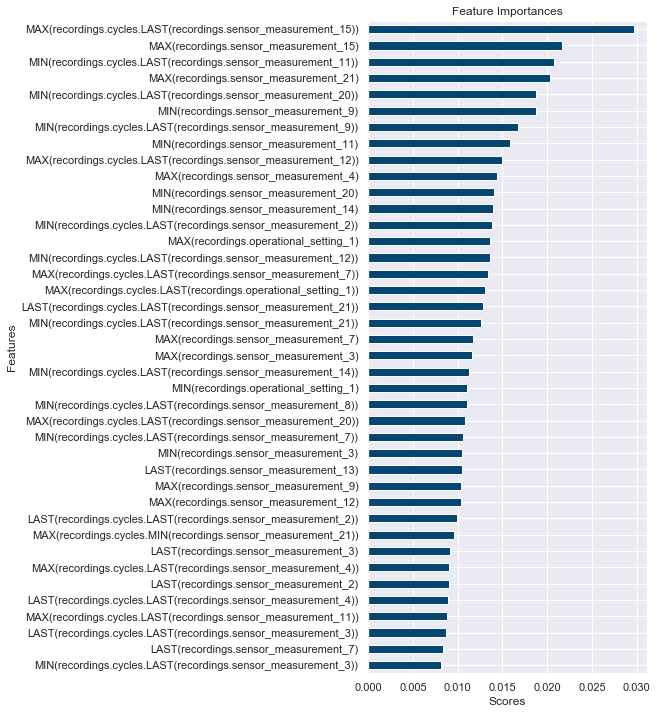

In [20]:
feature_importances = zip(x_train.columns, clf.feature_importances_)
feature_importances = pd.Series(dict(feature_importances))
feature_importances = feature_importances.rename_axis('Features')
feature_importances = feature_importances.sort_values()

top_features = feature_importances.tail(40)
plot = top_features.plot(kind='barh', figsize=(5, 12), color='#054571')
plot.set_title('Feature Importances')
plot.set_xlabel('Scores');